<a href="https://colab.research.google.com/github/Rachana-26/CNN-Based-Disease-Detection-in-fruits/blob/main/grapesfruit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the **Librairies** 



In [ ]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.8.0
Eager mode:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


**connecting to drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Loading the data


Create the training and validation directories

In [ ]:
import os
#Load data
#Create the training and validation directories
data_dir = "/content/gdrive/My Drive/cnn project/Grapes"
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

Label mapping


In [ ]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"

In [ ]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))

total images for training : /content/gdrive/My Drive/cnn project/Grapes/train : 3374files
total images for validation : /content/gdrive/My Drive/cnn project/Grapes/validation : 777files


In [ ]:
classes = ['blackmeasles','blackrot','fruit_blackrot','leafblight']   
print (classes)

['blackmeasles', 'blackrot', 'fruit_blackrot', 'leafblight']


In [ ]:
print('Number of classes:',len(classes))

Number of classes: 4


input data is resized to 224x224 pixels 



In [ ]:
IMAGE_SHAPE = (224, 224)

BATCH_SIZE = 64 #@param {type:"integer"}

Data Preprocessing

In [ ]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)

Found 777 images belonging to 4 classes.
Found 3374 images belonging to 4 classes.


**Transfer Learning with TensorFlow **

Select the TF2 module to use,Mobilenetv2

In [ ]:
IMAGE_SIZE = 224
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3) 
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False, 
    weights='imagenet'
)

9420800/9406464 [==============================] - 0s 0us/step


**Build the model**

In [ ]:
base_model.trainable=False 
model = tf.keras.Sequential([ 
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1024,activation='relu'),
  tf.keras.layers.Dense(512,activation='relu'),
  tf.keras.layers.Dense(4, #no.of classes
                        activation='softmax')
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

**Training Model**     
train model using validation dataset for validate each steps. After 10 epochs, we get **% for accuracy

In [ ]:
EPOCHS=15 #@param {type:"integer"}

history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//BATCH_SIZE
)

Epoch 1/15
52/52 [==============================] - 58s 1s/step - loss: 0.0490 - accuracy: 0.9813 - val_loss: 0.0490 - val_accuracy: 0.9779
Epoch 2/15
52/52 [==============================] - 50s 954ms/step - loss: 0.0280 - accuracy: 0.9885 - val_loss: 0.0760 - val_accuracy: 0.9792
Epoch 3/15
52/52 [==============================] - 48s 916ms/step - loss: 0.0302 - accuracy: 0.9888 - val_loss: 0.0604 - val_accuracy: 0.9701
Epoch 4/15
52/52 [==============================] - 48s 914ms/step - loss: 0.0373 - accuracy: 0.9843 - val_loss: 0.0652 - val_accuracy: 0.9753
Epoch 5/15
52/52 [==============================] - 48s 923ms/step - loss: 0.0360 - accuracy: 0.9885 - val_loss: 0.0429 - val_accuracy: 0.9779
Epoch 6/15
52/52 [==============================] - 50s 957ms/step - loss: 0.0310 - accuracy: 0.9885 - val_loss: 0.0482 - val_accuracy: 0.9805
Epoch 7/15
52/52 [==============================] - 49s 939ms/step - loss: 0.0347 - accuracy: 0.9879 - val_loss: 0.0930 - val_accuracy: 0.9635
Ep

In [ ]:
score = model.evaluate(validation_generator, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.04442765936255455
Test accuracy: 0.9832689762115479


**Checking Performance**      
Plot training and validation, accuracy and loss

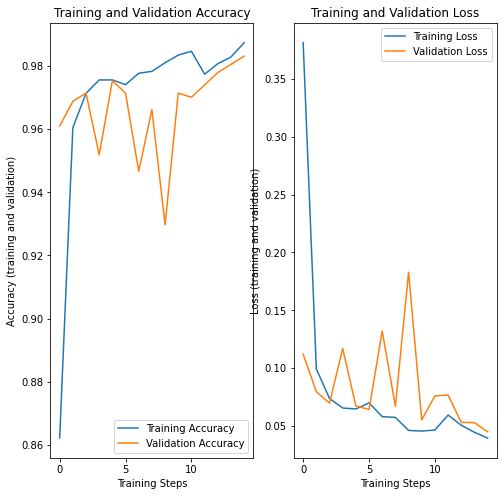

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

**Random test**       
Random five sample images from validation dataset and predict


In [ ]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: blackrot, file: blackrot/blackrot.91.jpg
PREDICTED: class: blackrot, confidence: 0.895523


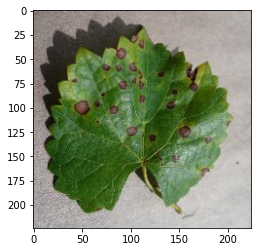

<Figure size 432x288 with 0 Axes>

SOURCE: class: blackmeasles, file: blackmeasles/blackmeasles.154.jpg
PREDICTED: class: blackmeasles, confidence: 0.984366


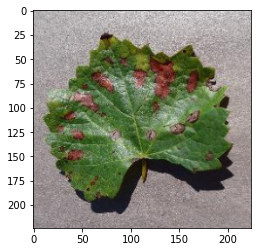

SOURCE: class: blackrot, file: blackrot/blackrot.176.jpg
PREDICTED: class: blackrot, confidence: 0.998847


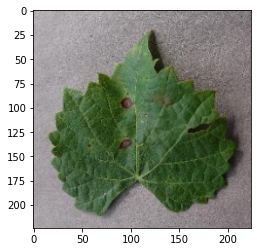

<Figure size 432x288 with 0 Axes>

SOURCE: class: blackrot, file: blackrot/blackrot.203.jpg
PREDICTED: class: blackrot, confidence: 0.976885


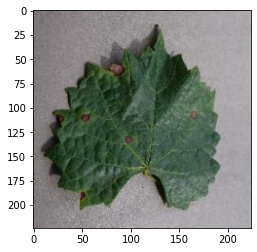

<Figure size 432x288 with 0 Axes>

SOURCE: class: fruit_blackrot, file: fruit_blackrot/fruit_blackrot (48).jpg
PREDICTED: class: fruit_blackrot, confidence: 1.000000


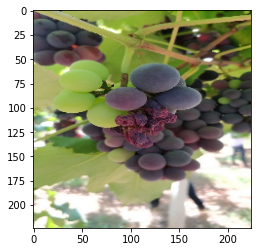

<Figure size 432x288 with 0 Axes>

SOURCE: class: blackmeasles, file: blackmeasles/blackmeasles.253.jpg
PREDICTED: class: blackmeasles, confidence: 0.999494


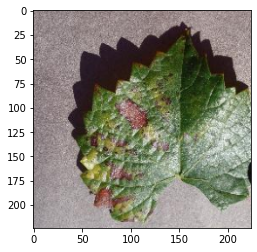

<Figure size 432x288 with 0 Axes>

SOURCE: class: blackrot, file: blackrot/blackrot.186.jpg
PREDICTED: class: blackrot, confidence: 0.992633


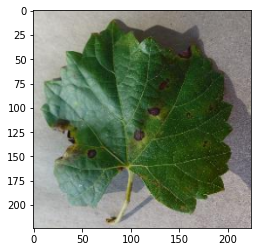

<Figure size 432x288 with 0 Axes>

SOURCE: class: blackrot, file: blackrot/blackrot.221.jpg
PREDICTED: class: blackrot, confidence: 0.589250


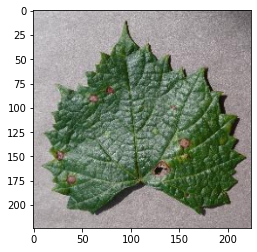

<Figure size 432x288 with 0 Axes>

SOURCE: class: blackrot, file: blackrot/blackrot.75.jpg
PREDICTED: class: blackrot, confidence: 0.997034


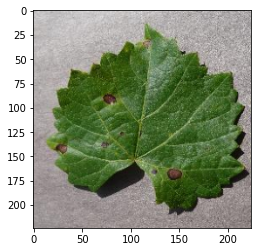

<Figure size 432x288 with 0 Axes>

SOURCE: class: blackmeasles, file: blackmeasles/blackmeasles.19.jpg
PREDICTED: class: blackmeasles, confidence: 0.999999


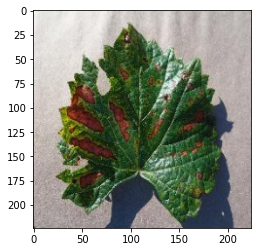

<Figure size 432x288 with 0 Axes>

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 10)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img[:,:,::-1])
    plt.figure(idx)    
    plt.show()

**Convert model to TensorFlow Lite**

In [ ]:
saved_model_dir = '' #means current directory
tf.saved_model.save(model, saved_model_dir) #saves to the current directory

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 
tflite_model = converter.convert() #converts our model into a .tflite model which flutter uses for ondevice machine learning

with open('grapes.tflite', 'wb') as f: #to write the converted model into a file, written as binary so add 'wb' instead of 'w'
  f.write(tflite_model)

In [ ]:
saved_model_dir

''